### Convolution neural networks

In [103]:
# importer
import torch
import numpy as np
import sys
import os
from torch.nn import Module, Conv2d, Linear, AvgPool2d, Sigmoid, LogSoftmax, CrossEntropyLoss, MaxPool2d
from torch.optim import Adam
from torch import flatten
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
sys.path.append(os.path.abspath(".."))
from ml_utils import vizualization, parse_config, decode_activation

In [104]:
VALID_JSON={
    "hpr_prm":
    {
        "type":"object",
        "properties":
        {
            "chanels":
            {
                "type":"integer",
                "enun":[1, 3]
            },
            "class_cnt":
            {
                "type":"integer"
            },
            "test_run":
            {
                "type":"bool"
            },
            "act_f":
            {
                "type":"string",
                "enum":["sig", "silu", "relu","identity"]
            },
            "lr":
            {
                "type":"number",
                "maximum":1.0
            },
            "architecture":
            {
                "type":"string",
                "enum":["lenet", "alexnet"]
            },
            "epochs":
            {
                "type":"integer",
                "minimum":10
            },
            "batch_size":
            {
                "type":"integer",
                "minimum":10
            }
        },
        "required":["architecture", "epochs", "batch_size", "lr", "test_run", "chanels", "class_cnt"]
    },
    "data":
    {
        "type":"object",
        "properties":
        {
            "x_normal":
            {
                "type":"number",
                "minimum":0.001,
                "maximum":1.0
            },
            "y_norm":
            {
                "type":"number",
                "minimum":0.001,
                "maximum":1.0
            },
            "dataset":
            {
                "type":
                {
                    "string"
                },
                "enum":["MNIST", "CIFAR10"]
            }
        }
    }
}

In [105]:
class LeNet(Module):
    def __init__(self, act_f_str:str) -> None:
        super().__init__()
        self.conv_l_1 = Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.act_1 = decode_activation(act_f_str)
        self.avg_pool_1 = AvgPool2d(kernel_size=2, stride=2)
        self.conv_l_2 = Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.act_2 = decode_activation(act_f_str)
        self.avg_pool_2 = AvgPool2d(kernel_size=2, stride=2)
        self.fullCon1 = Linear(in_features=16*4*4, out_features=120)
        self.act_3 = decode_activation(act_f_str)
        self.fullCon2 = Linear(in_features=120, out_features=84)
        self.act_4 = decode_activation(act_f_str)
        self.fullCon3 = Linear(in_features=84, out_features=10)
    
    def forward(self, x):
        # conv and pool
        x = self.avg_pool_1(self.act_1(self.conv_l_1(x)))
        x = self.avg_pool_2(self.act_2(self.conv_l_2(x)))
        
        # transform
        x = flatten(x, 1)

        # full connection
        return LogSoftmax(dim=1)(self.fullCon3(self.act_4(self.fullCon2(self.act_3(self.fullCon1(x))))))

class AlexNet(Module):
    def __init__(self, act_f_str:str, chanels:int, class_cnt:int) -> None:
        super().__init__()
        self.conv_l_1 = Conv2d(in_channels=chanels, out_channels=96, kernel_size=4, stride=4)
        self.act_1 = decode_activation(act_f_str)
        self.max_pool_1 = MaxPool2d(kernel_size=3, stride=2)
        self.conv_l_2 = Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        self.act_2 = decode_activation(act_f_str)
        self.max_pool_2 = MaxPool2d(kernel_size=3, stride=2)
        self.conv_l_3 = Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        self.act_3 = decode_activation(act_f_str)
        self.conv_l_4 = Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        self.act_4 = decode_activation(act_f_str)
        self.conv_l_5 = Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        self.act_5 = decode_activation(act_f_str)
        self.max_pool_3 = MaxPool2d(kernel_size=3, stride=2)
        self.full_con_l_1 = Linear(in_features=256*6*6, out_features=4906)
        self.act_6 = decode_activation(act_f_str)
        self.full_con_l_2 = Linear(in_features=4906, out_features=4906)
        self.act_7 = decode_activation(act_f_str)
        self.full_con_l_3 = Linear(in_features=4906, out_features=class_cnt)

    def forward(self, x):
        # conv and pool
        x = self.max_pool_1(self.act_1(self.conv_l_1(x)))
        x = self.max_pool_2(self.act_2(self.conv_l_2(x)))
        x = self.max_pool_3(self.act_5(self.conv_l_5(self.act_4(self.conv_l_4(self.act_3(self.conv_l_3(x)))))))
        # transform
        x = flatten(x, 1)
        # full conected
        return LogSoftmax(dim=1)(self.full_con_l_3(self.act_7(self.full_con_l_2(self.act_6(self.full_con_l_1(x))))))

### Prepare data for learning

In [106]:
def get_data(config:dict, datasrc:object, train_path:str, test_path:str, alex_net:bool):
    def data_transform(alex_net:bool):
        return [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((config['data']['x_norm']), (config['data']['y_norm']))] if alex_net else [
        transforms.ToTensor(),
        transforms.Normalize((config['data']['x_norm']), (config['data']['y_norm']))
        ]
    transform = transforms.Compose(data_transform(alex_net))#(0.1307), (0.3081)
    return  DataLoader(
        dataset=datasrc(root=train_path, train=True, transform=transform, download=True),
        batch_size=config['hpr_prm']['batch_size'], 
        shuffle=True,
        num_workers=4), DataLoader(
        dataset=datasrc(root=test_path, train=False, transform=transform, download=True),
        batch_size=config['hpr_prm']['batch_size'], 
        shuffle=True,
        num_workers=4)

def get_dataset_src(dataset_src_name:str):
    if dataset_src_name == 'MNIST': return datasets.MNIST
    else : return datasets.CIFAR10

In [107]:
def train(device:torch.device, model:object, config:dict, train_loader:DataLoader, criterion:CrossEntropyLoss, optimizer:Adam, test_run:bool):
    model.train()
    x_epoch = np.arange(0, 1 if test_run else config['hpr_prm']['epochs'])
    y_loss = np.zeros(1 if test_run else config['hpr_prm']['epochs'])

    for epoch in range(1 if test_run else config['hpr_prm']['epochs']):
        running_loss = 0.0
        loss = None
        for (data, target) in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if test_run:
                break
        y_loss[epoch] = running_loss/len(train_loader)
        print(f'Epoch {epoch+1} finished with avg loss: {running_loss/len(train_loader):.4f}')
    if not test_run:
        vizualization(x_epoch, 'epochs', y_loss, 'loss', 'loss over epochs')

def test(device:torch.device, model:object, test_loader:DataLoader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predict = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predict==target).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')


def learn(config:dict, data_path:str='data')->None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    train_loader, test_loader = get_data(config, get_dataset_src(config['data']['dataset']), f'{data_path}/train', f'{data_path}/test', config['hpr_prm']['architecture']=='alexnet')
    model = LeNet(config['hpr_prm']['act_f']).to(device) if config['hpr_prm']['architecture'] == 'lenet' else AlexNet(config['hpr_prm']['act_f'],config['hpr_prm']['chanels'], config['hpr_prm']['class_cnt']).to(device)
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), config['hpr_prm']['lr'])
    train(device, model, config, train_loader, criterion, optimizer, config['hpr_prm']['test_run'])
    if not config['hpr_prm']['test_run']:
        test(device, model, test_loader)

### Test 1
With LeNet for MNIST classification with Sigmoid activation function

cuda
Epoch 1 finished with avg loss: 0.6705
Epoch 2 finished with avg loss: 0.1621
Epoch 3 finished with avg loss: 0.1081
Epoch 4 finished with avg loss: 0.0833
Epoch 5 finished with avg loss: 0.0696
Epoch 6 finished with avg loss: 0.0596
Epoch 7 finished with avg loss: 0.0535
Epoch 8 finished with avg loss: 0.0481
Epoch 9 finished with avg loss: 0.0426
Epoch 10 finished with avg loss: 0.0399


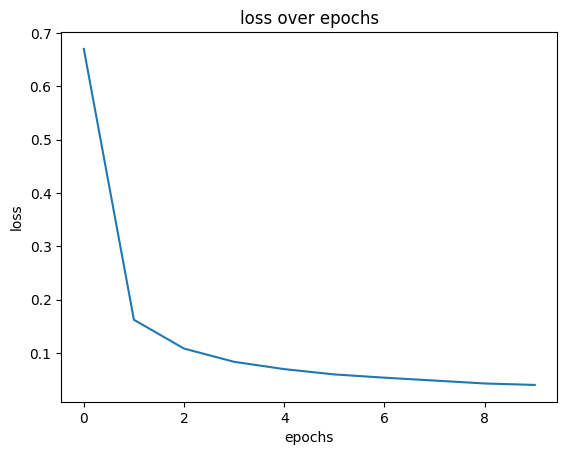

Accuracy on test set: 98.47%


In [108]:
config = parse_config('config/config1.json', VALID_JSON)
learn(config)

### Test 2
With LeNet for MNIST classification with ReLU activation function

cuda
Epoch 1 finished with avg loss: 0.2206
Epoch 2 finished with avg loss: 0.0705
Epoch 3 finished with avg loss: 0.0506
Epoch 4 finished with avg loss: 0.0392
Epoch 5 finished with avg loss: 0.0339
Epoch 6 finished with avg loss: 0.0281
Epoch 7 finished with avg loss: 0.0248
Epoch 8 finished with avg loss: 0.0204
Epoch 9 finished with avg loss: 0.0179
Epoch 10 finished with avg loss: 0.0156


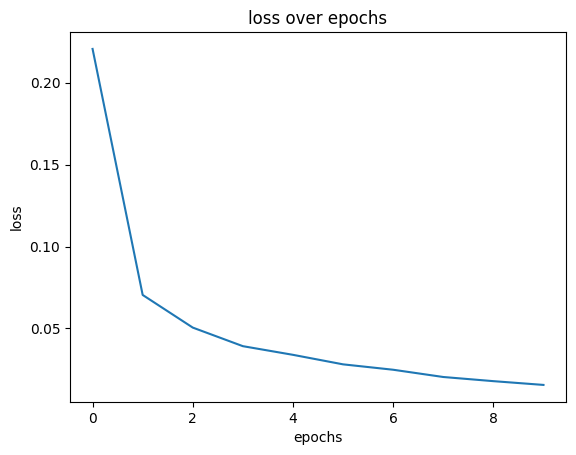

Accuracy on test set: 98.86%


In [109]:
config = parse_config('config/config2.json', VALID_JSON)
learn(config)

### Test 3
With AlexNet for MNIST classification with Sigmoid activation fucntion

In [ ]:
#config = parse_config('config/config3.json', VALID_JSON)
#learn(config)

### Test 4
With AlexNet for MNIST classification with ReLU activation fucntion

In [ ]:
#config = parse_config('config/config4.json', VALID_JSON)
#learn(config)

### Test 5
With AlexNet for CIFAR10 classification with ReLU activation function

In [ ]:
#config = parse_config('config/config5.json', VALID_JSON)
#learn(config, 'data1')